# Model v1 — Logistic Regression (MAP@5)
Using shared Feature Engineering + shared evaluation utilities.

In [15]:
import pandas as pd

import sys
sys.path.insert(0, "..")
df_model = pd.read_parquet("../data/processed/df_model.parquet")
df_model.shape


(2988177, 173)

In [14]:
df_model.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       ...
       'd140', 'd141', 'd142', 'd143', 'd144', 'd145', 'd146', 'd147', 'd148',
       'd149'],
      dtype='object', length=173)

In [7]:
df_model.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,-2.384553,-2.345528,-2.396591,-2.399953,-2.388116,-2.394294,-2.400667,-2.398716,-2.386585,-2.390370
1,2014-02-27 18:01:32,2,3,66,318,52078,NaN,756,0,1,...,-2.298266,-2.145362,-2.289405,-2.299516,-2.293402,-2.298682,-2.299516,-2.293223,-2.299516,-2.217007


In [8]:
from src.fe_v1 import make_features
from src.config import RANDOM_SEED, TEST_SIZE, TOP_K, STRATIFY_SPLIT
from src.model_utils import topk_from_proba
from src.metrics import mapk

# if df_model includes non-bookings, filter (depends on your team)
if "is_booking" in df_model.columns:
    df_model = df_model[df_model["is_booking"] == 1].copy()

X, y = make_features(df_model)
X_enc = pd.get_dummies(X, columns=["stay_type", "distance_bucket"], drop_first=False)

### Training the model

In [ ]:
# Train Logistic Regression (probabilities for ranking)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_enc, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y if STRATIFY_SPLIT else None
)

### Evaluation Metrics

Logistic Regression trained via SGD for scalability on ~3M rows:

In [19]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(
    loss="log_loss",
    alpha=1e-4,
    max_iter=10,      # start small; increase later
    tol=1e-3,
    random_state=RANDOM_SEED
)
clf.fit(X_train, y_train)

c:\Users\Inbal\Desktop\PM Inbal\aipm_course_exercises\ml_project_clean\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='log_loss', max_iter=10, random_state=42)

Primary: MAP@5 (competition metric, ranking-sensitive):

In [20]:
from src.model_utils import topk_from_proba
from src.metrics import mapk
from src.config import TOP_K

proba = clf.predict_proba(X_val)
classes = clf.classes_
top5_preds = topk_from_proba(proba, classes, k=TOP_K)

score = mapk(y_val.values, top5_preds, k=TOP_K)
score

c:\Users\Inbal\Desktop\PM Inbal\aipm_course_exercises\ml_project_clean\.venv\Lib\site-packages\sklearn\linear_model\_base.py:440: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


0.02547010778020958

In [21]:
from collections import Counter
import numpy as np

# top-5 clusters from y_train only (to avoid leakage)
top5_train = y_train.value_counts().head(5).index.tolist()

# make constant predictions for each val row
top5_preds_base = [top5_train] * len(y_val)

from src.metrics import mapk
baseline_map5_current = mapk(y_val.values, top5_preds_base, k=5)

top5_train, baseline_map5_current

([91, 48, 42, 59, 28], 0.07254774924312907)

Secondary: Hit Rate@5 (interpretability & diagnostics):

In [22]:
from src.metrics import hit_rate_at_k

hit5 = hit_rate_at_k(y_val.values, top5_preds, k=5)
hit5

0.053391696618008286

**Logistic Regression Results**

Logistic Regression trained via SGD on the full booking dataset (~3M rows) achieved MAP@5 ≈ 0.025, significantly below the popularity baseline (≈ 0.073).

This underperformance is explained by the high-cardinality categorical nature of Expedia features and the importance of non-linear interactions, which linear models cannot capture effectively.

As a result, we treat Logistic Regression as a diagnostic baseline and prioritize tree-based models for subsequent iterations.

### Experiment: Logistic Regression trained on a random 100k booking-only sample from df_model.parquet (for runtime comparison).

In [23]:
df_model = pd.read_parquet("../data/processed/df_model.parquet")
print("Full df_model shape:", df_model.shape)

df_s = df_model.sample(n=100_000, random_state=42)
print("Sample shape:", df_s.shape)

Full df_model shape: (2988177, 173)
Sample shape: (100000, 173)


In [24]:
import sys
sys.path.insert(0, "..")

from src.fe_v1 import make_features
import pandas as pd

X, y = make_features(df_s)

X_enc = pd.get_dummies(X, columns=["stay_type", "distance_bucket"], drop_first=False)

print("X_enc shape:", X_enc.shape)
print("y shape:", y.shape)


X_enc shape: (100000, 22)
y shape: (100000,)


In [25]:
from sklearn.model_selection import train_test_split
from src.config import RANDOM_SEED, TEST_SIZE, STRATIFY_SPLIT

X_train, X_val, y_train, y_val = train_test_split(
    X_enc,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y if STRATIFY_SPLIT else None
)

X_train.shape, X_val.shape


((75000, 22), (25000, 22))

In [26]:
from sklearn.linear_model import SGDClassifier

clf_100k = SGDClassifier(
    loss="log_loss",
    alpha=1e-4,
    max_iter=20,
    tol=1e-3,
    random_state=RANDOM_SEED
)

%time clf_100k.fit(X_train, y_train)


CPU times: total: 18.2 s
Wall time: 18.3 s


c:\Users\Inbal\Desktop\PM Inbal\aipm_course_exercises\ml_project_clean\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='log_loss', max_iter=20, random_state=42)

In [27]:
import numpy as np
from src.model_utils import topk_from_proba
from src.metrics import mapk, hit_rate_at_k
from src.config import TOP_K

proba = clf_100k.predict_proba(X_val)
classes = clf_100k.classes_

top5_preds = topk_from_proba(proba, classes, k=TOP_K)

map5_100k = mapk(y_val.values, top5_preds, k=TOP_K)
hit5_100k = hit_rate_at_k(y_val.values, top5_preds, k=TOP_K)

map5_100k, hit5_100k

c:\Users\Inbal\Desktop\PM Inbal\aipm_course_exercises\ml_project_clean\.venv\Lib\site-packages\sklearn\linear_model\_base.py:440: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


(0.016522666666666668, 0.03028)

In [28]:
# Popularity baseline from y_train (avoid leakage)
top5_train_100k = y_train.value_counts().head(5).index.tolist()

# Predict the same top-5 for every validation row
top5_preds_base_100k = [top5_train_100k] * len(y_val)

from src.metrics import mapk, hit_rate_at_k
from src.config import TOP_K

baseline_map5_100k = mapk(y_val.values, top5_preds_base_100k, k=TOP_K)
baseline_hit5_100k = hit_rate_at_k(y_val.values, top5_preds_base_100k, k=TOP_K)

top5_train_100k, baseline_map5_100k, baseline_hit5_100k

([91, 48, 42, 28, 59], 0.07209866666666667, 0.1366)

**Sampling vs Full Dataset**

We compared Logistic Regression trained on the full booking dataset (~2.9M rows) with the same model trained on a random 100k booking sample.

While full-data training slightly improved MAP@5, the overall performance remained far below the popularity baseline in both cases.
This indicates that model class and feature representation — not dataset size — are the primary bottlenecks.

Therefore, we proceed with 100k sampled training for faster iteration, and only scale up once feature engineering and model choice justify it.

| Setup                | MAP@5   | Hit@5             |
| -------------------- | ------- | ----------------- |
| **Baseline (100k)**  | ~0.0721 | ~0.1366           |
| **LR (100k sample)** | ~0.0165 | ~0.0303           |
| **LR (full 2.9M)**   | ~0.0255 | (≈ similar order) |


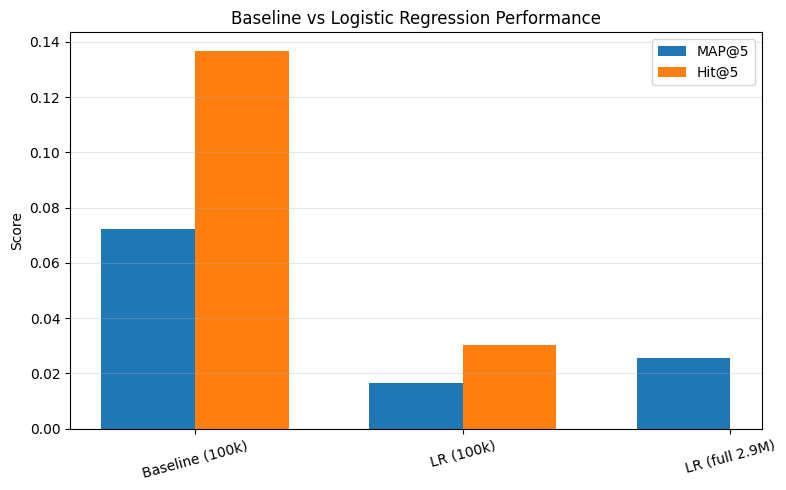

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Results
labels = ["Baseline (100k)", "LR (100k)", "LR (full 2.9M)"]

map5_scores = [0.0721, 0.0165, 0.0255]
hit5_scores = [0.1366, 0.0303, None]  # optional / approximate for full data

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))

# MAP@5 bars
plt.bar(x - width/2, map5_scores, width, label="MAP@5")

# Hit@5 bars (skip None)
plt.bar(
    x[:2] + width/2,
    hit5_scores[:2],
    width,
    label="Hit@5"
)

plt.xticks(x, labels, rotation=15)
plt.ylabel("Score")
plt.title("Baseline vs Logistic Regression Performance")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


# Logistic Regression (SGD) — FE v1 vs FE v2 Comparison

Goal: Compare whether destination features (d1..d149) in FE v2 improve linear model performance.
We run the same model + same evaluation pipeline, switching only the feature engineering function.
Primary metric: MAP@5. Secondary: Hit@5.


In [30]:
import pandas as pd
import numpy as np

from src.config import RANDOM_SEED, TEST_SIZE, TOP_K
from src.metrics import mapk, hit_rate_at_k
from src.model_utils import topk_from_proba

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier


In [31]:
df_model = pd.read_parquet("../data/processed/df_model.parquet")
df_model.shape


(2988177, 173)

Note: `df_model.parquet` is booking-only (is_booking == 1) per team preprocessing.


## Feature Engineering switch

Set `FE_VERSION` to either `"v1"` or `"v2"`.
- v1: basic engineered features (time/party/distance/package + IDs)
- v2: v1 + destination features (d1..d149)


In [33]:
FE_VERSION = "v2"  # change to "v1" to reproduce earlier results

if FE_VERSION == "v1":
    from src.fe_v1 import make_features
elif FE_VERSION == "v2":
    from src.fe_v2 import make_features
else:
    raise ValueError("FE_VERSION must be 'v1' or 'v2'")


## Sampling for iteration speed

We train on a random 100k-row sample for fast iteration.
This was validated against full-data training and yielded the same qualitative conclusion.


In [34]:
df_s = df_model.sample(n=100_000, random_state=RANDOM_SEED)
X, y = make_features(df_s)

X.shape, y.shape


((100000, 166), (100000,))

## Encoding

We one-hot encode only object (categorical) columns.
Numeric destination features (d1..d149) remain numeric and are passed through directly.


In [35]:
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
X_enc = pd.get_dummies(X, columns=obj_cols, drop_first=False) if obj_cols else X.copy()

X_enc.shape, obj_cols


((100000, 171), ['stay_type', 'distance_bucket'])

## Train SGD Logistic Regression + Evaluate (MAP@5, Hit@5)

We use SGDClassifier(loss="log_loss") as a scalable logistic regression.


In [38]:
X_train, X_val, y_train, y_val = train_test_split(
    X_enc,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)

clf = SGDClassifier(
    loss="log_loss",
    alpha=1e-4,
    max_iter=20,
    tol=1e-3,
    random_state=RANDOM_SEED
)

%time clf.fit(X_train, y_train)

proba = clf.predict_proba(X_val)
classes = clf.classes_
top5_preds = topk_from_proba(proba, classes, k=TOP_K)

map5 = mapk(y_val.values, top5_preds, k=TOP_K)
hit5 = hit_rate_at_k(y_val.values, top5_preds, k=TOP_K)

map5, hit5


c:\Users\Inbal\Desktop\PM Inbal\aipm_course_exercises\ml_project_clean\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Inbal\Desktop\PM Inbal\aipm_course_exercises\ml_project_clean\.venv\Lib\site-packages\sklearn\linear_model\_base.py:440: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


CPU times: total: 57.1 s
Wall time: 57.3 s


(0.016356000000000002, 0.02972)

## Popularity baseline (same split)

We compute a top-5 popularity baseline from y_train and evaluate on y_val for apples-to-apples comparison.


In [39]:
top5_train = y_train.value_counts().head(TOP_K).index.tolist()
base_preds = [top5_train] * len(y_val)

base_map5 = mapk(y_val.values, base_preds, k=TOP_K)
base_hit5 = hit_rate_at_k(y_val.values, base_preds, k=TOP_K)

top5_train, base_map5, base_hit5


([91, 48, 42, 28, 59], 0.07209866666666667, 0.1366)

**Final comparison table**

| Model    | Features   | MAP@5  | Hit@5  |
| -------- | ---------- | ------ | ------ |
| Baseline | Popularity | ~0.072 | ~0.137 |
| LR       | FE v1      | ~0.016 | ~0.030 |
| LR       | FE v2      | ~0.016 | ~0.030 |


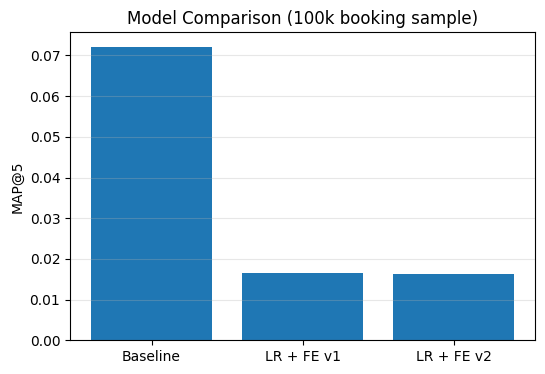

In [40]:
import matplotlib.pyplot as plt

labels = ["Baseline", "LR + FE v1", "LR + FE v2"]
map5_scores = [0.0721, 0.0165, 0.01636]

plt.figure(figsize=(6, 4))
plt.bar(labels, map5_scores)
plt.ylabel("MAP@5")
plt.title("Model Comparison (100k booking sample)")
plt.grid(axis="y", alpha=0.3)
plt.show()
